In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ephem
import math
from datetime import timedelta
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
import glob



In [3]:
def calculate_solar_cos_zenith(datetime_obj):
    observer = ephem.Observer()
    latitude  = 38.980762    # ERW
    longitude = -107.005017  # ERW
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = datetime_obj

    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude

    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith

def calculate_solar_az(datetime_obj):
    observer = ephem.Observer()
    lat  = 38.980762    # ERW
    lon = -107.005017  # ERW
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.date = datetime_obj
    sun = ephem.Sun(observer)

    return sun.az

def convert_to_minute_of_day(dt):
    minute_of_day = dt.hour * 60 + dt.minute
    return minute_of_day

In [4]:
gndir = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/gucgndir/all_irt.nc")
irt = gndir.sfc_ir_temp.to_pandas()


In [5]:
qcrad = xr.open_mfdataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/qcrad/*cdf")

In [6]:
kolias = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/kollias/cbh_kolias2.nc").to_pandas()
cloud_present_kolias = kolias.copy()
cloud_present_kolias[cloud_present_kolias == -1] = 0
cloud_present_kolias[cloud_present_kolias > 6000 ] = 0
cloud_present_kolias[cloud_present_kolias > 0] = 1


In [7]:
# let's look at the clear sky albedo.. 
qcswd = qcrad.BestEstimate_down_short_hemisp.where(qcrad.qc_BestEstimate_down_short_hemisp==0)
qcswu = qcrad.up_short_hemisp.where(qcrad.qc_up_short_hemisp==0)

In [8]:
df1min = pd.DataFrame({"swd":qcswd.to_pandas(), "swu":qcswu.to_pandas()})
df1min['cbh'] = cloud_present_kolias.resample("1min").interpolate(method='linear').reindex(df1min.index)
df1min['actual_cbh'] = kolias.resample("1min").interpolate(method='linear').reindex(df1min.index)
df1min['cza'] = df1min.index.map(calculate_solar_cos_zenith)
df1min['az'] = df1min.index.map(calculate_solar_az)
df1min.swu = df1min.swu.clip(lower=0)
df1min.swd = df1min.swd.clip(lower=0)
df1min.cza = df1min.cza.clip(lower=0)
broadband_alb = (df1min.swu/df1min.swd).where(df1min.cza>.2)

In [9]:
master_df = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre.csv", index_col=0, parse_dates=True)
cre_sw = (master_df.qcrad_swd - master_df.rrtmg_swd_clear).where(master_df.shadow<.3).fillna(0)
cre_lw = (master_df.qcrad_lwd - master_df.rrtmg_lwd_clear)
crf_sw = (cre_sw * (1-master_df.albedo))
crf_lw = cre_lw + (master_df.ml_lwu_clear - master_df.qcrad_lwu)
crf_net = crf_sw + crf_lw
cre_net = cre_sw + cre_lw

In [10]:
daytime_crf   = crf_net.where(master_df.cza>0).dropna().resample("1d").mean()#.plot()
nighttime_crf = crf_net.where(master_df.cza<0).dropna().resample("1d").mean()#.plot()
alltime_crf   = crf_net.dropna().resample("1d").mean()
#plt.axhline(0)

In [11]:
mfsr = xr.open_mfdataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/mfsr/ftp.archive.arm.gov/rudisillw2/243346/*.nc")

In [12]:
mfsr_sub = mfsr.sel(time=slice("2022-01-01", "2023-07-01"))

In [13]:
### open up the... upwelling 
mfrsr_up = xr.open_mfdataset("/global/homes/r/rudisill/gshare2/will_data/mfrsr_down/*.nc")

In [14]:
mfrsr_up_sub = mfrsr_up.sel(time=slice("2022-01-01", "2023-07-01"))

In [15]:
up_1624 = mfrsr_up_sub.up_hemisp_narrowband_filter7.to_pandas()
up_936  = mfrsr_up_sub.up_hemisp_narrowband_filter6.to_pandas()
up_866  = mfrsr_up_sub.up_hemisp_narrowband_filter5.to_pandas()
up_673  = mfrsr_up_sub.up_hemisp_narrowband_filter4.to_pandas()
up_610  = mfrsr_up_sub.up_hemisp_narrowband_filter3.to_pandas()
up_497  = mfrsr_up_sub.up_hemisp_narrowband_filter2.to_pandas()
up_409  = mfrsr_up_sub.up_hemisp_narrowband_filter1.to_pandas()

#mfrsr_up_sub.up_hemisp_narrowband_filter1

In [16]:
updf = pd.DataFrame([up_1624, up_936, up_866, up_673, up_610, up_497, up_409]).T
updf.columns = ["1624", "936", "866", "673", "610", "497", "409"]


In [17]:
down_1624 = mfsr_sub.hemisp_narrowband_filter7.to_pandas()
down_936  = mfsr_sub.hemisp_narrowband_filter6.to_pandas()
down_866  = mfsr_sub.hemisp_narrowband_filter5.to_pandas()
down_673  = mfsr_sub.hemisp_narrowband_filter4.to_pandas()
down_610  = mfsr_sub.hemisp_narrowband_filter3.to_pandas()
down_497  = mfsr_sub.hemisp_narrowband_filter2.to_pandas()
down_409  = mfsr_sub.hemisp_narrowband_filter1.to_pandas()

#mfrsr_up_sub.up_hemisp_narrowband_filter1

In [18]:
dndf = pd.DataFrame([down_1624, down_936, down_866, down_673, down_610, down_497, down_409]).T
dndf.columns = ["1624", "936", "866", "673", "610", "497", "409"]


In [19]:
updf_noon_1h = updf[updf.index.hour.isin([19])].resample("1h").mean().dropna()

In [20]:
dndf_noon_1h = dndf[dndf.index.hour.isin([19])].resample("1h").mean().dropna()

In [21]:
# (updf_noon_1h/dndf_noon_1h).plot(marker='o')
# plt.ylim(0,1.2)

# broadband_alb[broadband_alb.index.hour.isin([19])].resample("1h").mean()["2022-01-01" : "2023-07-01"].dropna().plot(color='black')

# plt.grid(alpha=.5)


In [22]:
cfrac = cloud_present_kolias.resample("1h").mean()


In [23]:
cfrac['cza'] = cfrac.index.map(calculate_solar_cos_zenith)

In [24]:
day_cloud = cfrac.where(cfrac.cza>0).dropna().resample("1d").mean()
night_cloud = cfrac.where(cfrac.cza<0).dropna().resample("1d").mean()


In [25]:
# sd = "2022-03-01"
# ed = "2022-06-01"

# fig,axx = plt.subplots(3, gridspec_kw={'height_ratios': [1,1,2]})
# ax   = axx[2]
# axt  = axx[1]
# axt0 = axx[0]

# # plot the albedo
# alb = (updf_noon_1h/dndf_noon_1h)[sd:ed].resample("1d").mean()
# leg = alb.plot(ax=ax, legend=False, marker='o')#linewidth=1)
# ax.set_ylim(0, 1.1)
# ax.grid()

# #ax.legend(loc='upper right', bbox_to_anchor=(2.5, 1.5))
# broadband_alb[broadband_alb.index.hour.isin([19])].resample("1h").mean()[sd:ed].dropna().resample("1d").mean().plot(ax=ax,color='black')

# ### make the top plot 
# axt.bar(daytime_crf[sd:ed].index,   daytime_crf[sd:ed],     color='orange')
# bottom_positions = daytime_crf[sd:ed].where(daytime_crf[sd:ed]>0, 0)
# axt.bar(nighttime_crf[sd:ed].index, nighttime_crf[sd:ed], bottom=bottom_positions,   color='purple')
# axt.bar(nighttime_crf[sd:ed].index, nighttime_crf[sd:ed]+daytime_crf[sd:ed],   facecolor='none', edgecolor='red', linewidth=1)



# #nighttime_crf[sd:ed]
# axt.set_xticks([])
# axt0.set_xticks([])

# # set the limits...
# ax.set_xlim(pd.Timestamp(sd), pd.Timestamp(ed))
# axt.set_xlim(pd.Timestamp(sd), pd.Timestamp(ed))
# axt0.set_xlim(pd.Timestamp(sd), pd.Timestamp(ed))

# # make a line for the top plot ....
# axt.axhline(0, color='black')
# axt.grid()

# ax.axhline(.6, color='red', linestyle='--')
# ax.axvline(pd.to_datetime("2022-05-09"), linestyle='--')
# axt.axvline(pd.to_datetime("2022-05-10"), linestyle='--')
# axt0.axvline(pd.to_datetime("2022-05-10"), linestyle='--')

# axt0.bar(night_cloud[sd:ed].index,  night_cloud[sd:ed].cloud_base_best_estimate, color='purple')
# axt0.bar(day_cloud[sd:ed].index,   day_cloud[sd:ed].cloud_base_best_estimate, bottom=night_cloud[sd:ed].cloud_base_best_estimate,  color='orange')


# axt2 = ax.twinx()
# irt1h = irt.resample("1h").mean()[sd:ed]
# irt1h_noon = irt1h[irt1h.index.hour.isin([19])]
# axt2.plot(irt1h_noon.index, irt1h_noon, color='red', linewidth=1)
# axt2.axhline(273.15)
# axt2.set_ylim(265, 280)




In [26]:
from matplotlib.ticker import MultipleLocator


In [27]:
# albx = broadband_alb[broadband_alb.index.hour.isin([19])].resample("1h").mean()[sd:ed].dropna().resample("1d").mean()
# #plt.scatter(daytime_crf, albx.loc[daytime_crf.index], color='orange')

In [28]:
import act 
from PIL import Image
import shutil
import pathlib as pl
import subprocess

token='7915e9fe3c987b12'
sd = "2023-03-01"
ed = "2023-06-01"


dest = pl.Path("/global/homes/r/rudisill/gshare2/will_data/radiation_timeseries/images_scratch/temp_folder_albedo22") # _psp")
# dest.mkdir(parents=False, exist_ok=True)


# d1 = "".join(sd.split("-"))
# d2 = "".join(ed.split("-"))
# files = list(sorted(dest.glob("*%s*.jpg"%d1))) + list(sorted(dest.glob("*%s*.jpg"%d2)))

# # files = []
# # for x in pd.date_range(sd, ed, freq='D'):
# #     files = files + list(dest.glob("*%s*.jpg"%x.strftime("%Y%m%d")) )
# # files=sorted(files)
# # t3=files[220]
# # img = Image.open(t3)
# # image_array = np.array(img)
# # plt.imshow(image_array)



# def untar_archive(archive_path, extract_path):
#     try:
#         subprocess.run(["tar", "-xf", archive_path, "-C", extract_path])
#     except subprocess.CalledProcessError as e:
#         print(f"Extraction failed with error: {e}")

# output_file = act.discovery.download_data(
#     "willrudisill", token, "guccamgndradpirM1.a1", sd, ed, output=dest
# )


# for x in output_file:
#     untar_archive(x, dest)





In [29]:
def get_file_from_date(datetime):
    return list(dest.glob("*%s*.jpg"%datetime.strftime("%Y%m%d.%H")))



### prepare the data...

In [30]:
# regular albedo
alb = (updf_noon_1h/dndf_noon_1h).resample("1d").mean()[['409', '497', '610', '673', '866', '936']]

# broadband albedo
balb = broadband_alb[broadband_alb.index.hour.isin([19])].resample("1h").mean()[sd:ed].dropna().resample("1d").mean()


# irt 
irt1h = irt.resample("1h").mean()[sd:ed]
irt1h_noon = irt1h[irt1h.index.hour.isin([19])] - 273.15


In [36]:
balb

time
2023-03-01    0.914002
2023-03-02    0.811400
2023-03-03    0.906161
2023-03-04    0.864068
2023-03-05    0.879179
                ...   
2023-05-28    0.162330
2023-05-29    0.161500
2023-05-30    0.161613
2023-05-31    0.161051
2023-06-01    0.134787
Freq: D, Length: 93, dtype: float32

/tmp/ipykernel_738022/2607995407.py:132: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axtoplist[1].annotate(


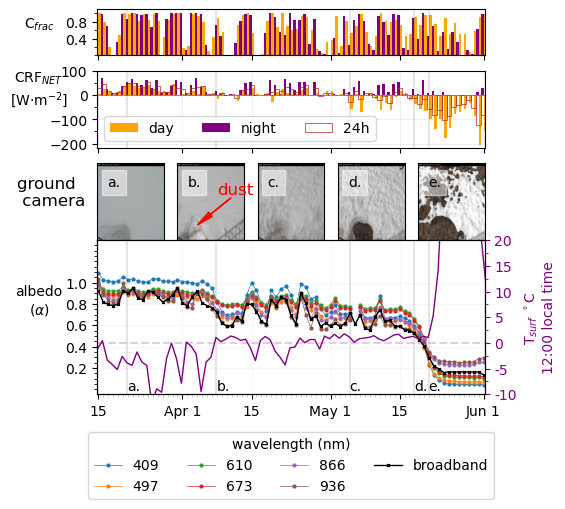

In [63]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(5, 5))

# Create a GridSpec with 4 rows and 5 columns
                                       
gs = gridspec.GridSpec(6,5, height_ratios=[.3,  # day cloud 
                                           .1,  # spacing 
                                           .5,  # crf 
                                           .1,  # images 
                                           .5,  # spacing 
                                            1]) # albedo 

# Add subplots to the top row (5 subplots spanning the width of the figure)
dlist = ["2023-03-20 21", "2023-04-07 21", "2023-05-04 21", "2023-05-17 21", "2023-05-20 21"]

axtoplist = []
letterlist = ['a.','b.','c.','d.','e.']

for i,d in enumerate(dlist):
    ax = fig.add_subplot(gs[4, i])
    ax.set_xticks([])
    ax.set_yticks([])
    f=get_file_from_date(pd.to_datetime(d))
    img = Image.open(f[0])
    image_array = np.array(img)
    ax.imshow(image_array, aspect='auto')   
    tx = ax.text(.15,.7, letterlist[i], color='black', transform=ax.transAxes)
    tx.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    axtoplist.append(ax)

# Add a subplot to the bottom 3 rows spanning the entire width
#ax1  = fig.add_subplot(gs[0, :])
ax2  = fig.add_subplot(gs[0, :])
ax3  = fig.add_subplot(gs[2, :])
ax4  = fig.add_subplot(gs[5, :])


###################
sd = "2023-03-15"
#ed = "2023-06-01"
ed = "2023-06-01"
bwidth = 1




# make the ...
ax2.bar(day_cloud[sd:ed].index,    day_cloud[sd:ed].cloud_base_best_estimate,   width=.5,align='edge',  color='orange')
ax2.bar(night_cloud[sd:ed].index,  night_cloud[sd:ed].cloud_base_best_estimate, width=-.5,align='edge',  color='purple')

### make the top plot 
bottom_positions = daytime_crf[sd:ed].where(daytime_crf[sd:ed]>0, 0)
ax3.bar(alltime_crf[sd:ed].index,   daytime_crf[sd:ed],   width =   .5, align='edge', color='orange', label='day')
ax3.bar(alltime_crf[sd:ed].index,   nighttime_crf[sd:ed], width =   -.5, align='edge',  color='purple', label='night') 
ax3.bar(alltime_crf[sd:ed].index,   alltime_crf[sd:ed],   width =   1,   facecolor='none', edgecolor='firebrick', linewidth=.5, label='24h')






ax3.legend(ncol=3)


# plot the albedo
leg = ax4.plot(alb.index, alb, linewidth=.5, marker='o', markersize=2, label=alb.columns)
ax4.plot(balb.index, balb, linewidth=1, marker='x', markersize=2, color='black', label='broadband')

leg = ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4) #len(alb.columns)+1)
leg.set_title("wavelength (nm)")

## add the snow skin temperature
ax42 = ax4.twinx()
ax42.plot(irt1h_noon.index, irt1h_noon, color='purple', linewidth=1)
ax42.set_ylim(-10, 20)


# remove the xticks from the plot...
for axx in [ax1, ax2,ax3,ax4]:
    axx.set_xlim(pd.Timestamp(sd)-timedelta(hours=6), pd.Timestamp(ed)+timedelta(hours=6))

for lab,d in zip(['a.','b.','c.','d.','e.'], dlist):
    #axx.axvline(pd.Timestamp(d), linestyle='--', color='black', alpha=.5)
    ax4.text(pd.Timestamp(d), -.01, lab, color='black')
    for axx in [ax1, ax2, ax3, ax4]:
        axx.axvline(pd.Timestamp(d), linestyle='-', color='black', alpha=.1)

# remove the xticks from the plot...
for axx in [ax1, ax2, ax3]:
    axx.set_xticklabels([])


#### do some more styling down here...
# fix the tick labels 
ax3.set_yticks(np.arange(-200, 200, 100))
ax3.yaxis.set_minor_locator(MultipleLocator(50))


# fix the tick labels 
ax4.set_yticks(np.arange(.2, 1.2, .2))
ax4.yaxis.set_minor_locator(MultipleLocator(.05))
ax4.set_ylabel("albedo\n"+r"($\alpha$)", rotation=0)
ax42.set_ylabel("T$_{surf}$ $^\circ$C"+"\n"+"12:00 local time", color='purple')
ax42.set_yticks(np.arange(-10,25,5))
ax42.yaxis.set_minor_locator(MultipleLocator(2.5))
ax42.set_yticklabels(ax42.get_yticks(), color='purple')
ax42.tick_params(axis='y', colors='purple')
ax42.tick_params(axis='y', which='minor', colors='purple')

# set the ticks of the middle plot 
#axt.set_ylim(-100, 80)
ax3.set_yticks(np.arange(-200, 200, 100))
ax3.yaxis.set_minor_locator(MultipleLocator(50))
ax3.grid(alpha=.2)
ax3.set_ylabel("CRF$_{NET}$" +"\n"+ "[W$\cdot$m$^{-2}$]", rotation=0)

ax2.set_ylabel("C$_{frac}$", rotation=0)
#ax2.set_ylabel("\night", rotation=0)

# style the top
#axt0.set_yticks([0,1,2])
#axt0.yaxis.set_minor_locator(MultipleLocator(.5))
#axt0.set_ylabel("C$_{frac}$")

##########################
# label the top 
axtoplist[1].text(.6, .6, "dust", fontsize=12, color='red', transform=axtoplist[1].transAxes)
axtoplist[1].annotate(
    '', xy=(0.3, 0.2), xytext=(0.8, 0.55),
    arrowprops=dict(facecolor='red', color='red',width=0.005, headwidth=4),
    xycoords='axes fraction', textcoords='axes fraction'
)


### align all of the y labels 
labelx = -0.15  # axes coords
for axx in [axtoplist[0], ax1, ax2, ax3, ax4]:
    axx.yaxis.set_label_coords(labelx, 0.5)


cloudax = [ax1,ax2]
for axx in cloudax:
    axx.set_ylim(0, 1.1)
    axx.yaxis.set_minor_locator(MultipleLocator(.2))
    axx.set_yticks([.4,.8])

ax4.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))
ax4.xaxis.set_minor_locator(mdates.DayLocator())

# Define a custom date formatter
def format_date(x, pos):
    date = mdates.num2date(x)
    if date.day == 1:
        return date.strftime('%b %-d')
    else:
        return date.strftime('%-d')

# Apply the custom formatter to the x-axis
ax4.xaxis.set_major_formatter(plt.FuncFormatter(format_date))
ax4.xaxis.set_minor_formatter(plt.FuncFormatter(lambda x, pos: ''))
ax4.grid(alpha=.1)
#ax4.axhline(.6, color='red', linestyle='--', alpha=.2)
ax42.axhline(0, color='purple', linestyle='--', alpha=.2)

# Rotate and align the tick labels
#fig.autofmt_xdate()

axtoplist[0].text(-1.2, .45, "ground \n camera", fontsize=12, color='black', transform=axtoplist[0].transAxes)

##### TODO: SET A SPECIFIC TICK LABEL COLOR 
#ax4.get_xticklabels()[1].set_color("red")

#ax4.text(.05, -.15, "2023", fontsize=10, color='black', transform=ax4.transAxes)

plt.subplots_adjust(hspace=0)

ax4.tick_params(axis='x', which=u'minor',length=2, color=[0,0,0,0.25])

plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_dust_on_snow.png", dpi=600, bbox_inches='tight')

In [33]:
dr

NameError: name 'dr' is not defined

<BarContainer object of 79 artists>

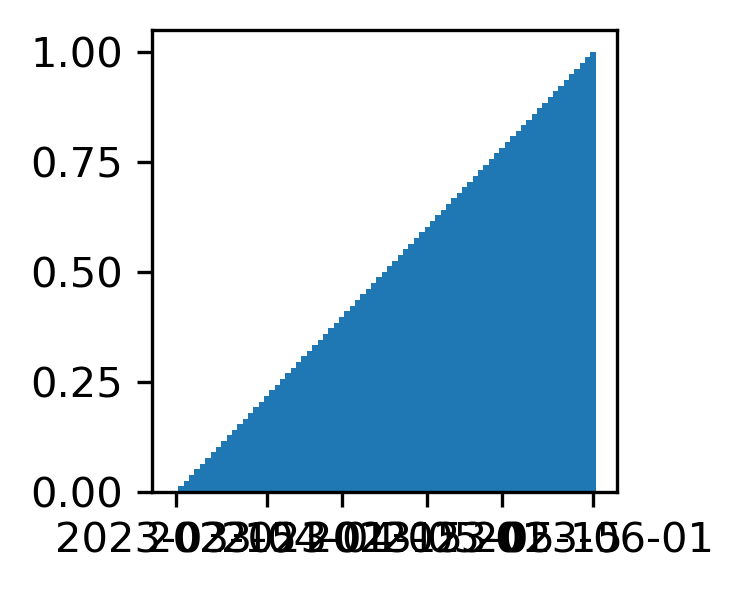

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(2,2),dpi=300)


dr = pd.date_range(sd, ed, freq='D')
dr.freq = None

ax.bar(dr, height = np.linspace(0, 1, len(dr)), width=1)

In [ ]:
np.linspace(0, len(dr), 1)

array([0.])

In [ ]:
help(ax4.xaxis.set_minor_formatter)

Help on method set_minor_formatter in module matplotlib.axis:

set_minor_formatter(formatter) method of matplotlib.axis.XAxis instance
    Set the formatter of the minor ticker.
    
    In addition to a `~matplotlib.ticker.Formatter` instance,
    this also accepts a ``str`` or function.
    See `.Axis.set_major_formatter` for more information.
    
    Parameters
    ----------
    formatter : `~matplotlib.ticker.Formatter`, ``str``, or function



In [ ]:
ax4.get_xticks()

array([19431., 19448., 19462., 19478., 19492., 19509.])